# ===== FILE SETUP ======# 

In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="winter_vernalization"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="do3se_phenology"
BRANCH="add-vernalisation"
DEPENDENCIES=[
    ("thermal_time", "github.com/SEI-DO3SE/thermal_time.git@RELEASE"),
    ("do3se_phenology", f"github.com/SEI-DO3SE/do3se_phenology.git@{BRANCH}"),
    ("notebook_utils", f"github.com/sbland/notebook_utils"),
    ("py_data_helpers", f"github.com/sbland/py_data_helpers.git@RELEASE"),
    ("do3se_met", "github.com/SEI-DO3SE/do3se_met.git"),
]

In [3]:
# Create colab link
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/{BRANCH}/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/do3se_phenology/blob/add-vernalisation/notebooks/winter_vernalization.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except (ImportError, ModuleNotFoundError):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            print(f"------ Installing {name}----------------")
            try:
                stdout = !pip install git+https://{user}:{token}@{path}
                if "Host key verification failed" in "\n".join(stdout):
                    print(f"------------- Failed to install with dependencies for {name} ---------------")
                    # If it fails to install try installing without dependencies
                    # git+ssh dependencies will currently fail
                    !pip install git+https://{user}:{token}@{path} --no-deps
            except:
                print(f"Failed to install all of {name} at {path}")
            finally:
                print("\n".join(stdout))
        creds.close()
        creds = None
        creds_parsed = None
        user = None
        token = None

# ===== END OF FILE SETUP ======# 
----

# Import dependencies

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from dataclasses import dataclass
from typing import List
from itertools import accumulate
import notebook_utils 
import ipywidgets as widgets
from notebook_utils.widgets import interact_plus_reset

In [6]:
%load_ext autoreload
%autoreload 2


from do3se_phenology.phyllochron_dvi import *
from do3se_phenology.td_percent_definition import *
from do3se_phenology.f_phen import *
from do3se_phenology.plots import *
from do3se_phenology.vernalisation import *

# Add local dependencies here

In [7]:
from do3se_met.irradiance import *
from thermal_time.calcs import *

---

# Winter Vernalization


In [8]:
day_count = 365
lat = 20

dd_data = np.array([[d for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
hrs_data = np.array([[i for i in range(24)] for d in range(day_count)]).reshape(day_count * 24)
demo_temp_data = [24-abs(hr-12) for hr in hrs_data]
accumulated_temperatures = list(accumulate(demo_temp_data))


In [9]:
# Calc thermal time and photoperiod
T_b, T_o, T_m = [0,20,50]
lat = 50
p_crit=24
p_sens=0
tsc = demo_temp_data
td = calc_thermal_time_range(tsc, t_b=T_b)
# teff = [calc_effective_temperature(sum(tsc[d*24:(d+1)*24]),T_b, T_o, T_m) for d in dd_data]
photoperiod = [calc_photoperiod(dd, lat) for dd in dd_data]
rpe = [calc_rpe(p_crit=p_crit, p_sens=p_sens, p=P) for P in photoperiod]

# Vernalisation (Single Day)

In [10]:
min_temp = 8.1333
max_temp = 22.1633
v_T_min = 15.0
v_T_max = 30.0

max_crown_temp = 22.1633 # 
min_crown_temp = 8.133 # 
t_leaf = (max_crown_temp+min_crown_temp)/2 # Crown temp

a = 1.4-0.0778*t_leaf
b = 0.5+13.44*t_leaf/(max_temp-min_temp+3)**2.0
Vc = min(a,b)

# Vernalisation
V_pos = Vc if min_temp < v_T_min and max_temp < v_T_max else 0
print(f'Vernalisation: {V_pos}')

# Devernalisation
Vd = min(0.5*(max_temp-v_T_max), 0)
V_neg = Vd if max_temp > v_T_max else 0
print(f'Devernalisation: {V_neg}')

# Total Vernalisation
V = V_pos + V_neg
print(f'Total Vernalisation: {V}')

# Vernalisation factor
PIV = 1.5 #PIV (empirical coefficient-varies according to different genetic structure of wheat cultivars)
Vf = 1- (0.0054545*PIV+0.0003)*(50-V) 
print(f'Vernalisation Factor: {Vf}')

Td = 10
TdV = Td * Vf
print(f'Thermal Time Vernalised: {TdV}')


Vernalisation: 0.22147393000000015
Devernalisation: 0
Total Vernalisation: 0.22147393000000015
Vernalisation Factor: 0.5777909865057775
Thermal Time Vernalised: 5.777909865057776


In [11]:
def calc_vernalisation_factor(
    min_temp: float,
    max_temp: float,
    v_T_min: float,
    v_T_max: float,
    max_crown_temp: float,
    min_crown_temp: float,
) -> float:
    t_leaf = (max_crown_temp+min_crown_temp)/2 # Crown temp

    # TODO: Are these values coefficients?
    a = 1.4-0.0778*t_leaf
    b = 0.5+13.44*t_leaf/(max_temp-min_temp+3)**2.0
    Vc = min(a,b)

    # Vernalisation
    V_pos = Vc if min_temp < v_T_min and max_temp < v_T_max else 0
    print(f'Vernalisation: {V_pos}')

    # Devernalisation
    Vd = min(0.5*(max_temp-v_T_max), 0)
    V_neg = Vd if max_temp > v_T_max else 0
    print(f'Devernalisation: {V_neg}')

    # Total Vernalisation
    V = V_pos + V_neg
    print(f'Total Vernalisation: {V}')

    # Vernalisation factor
    PIV = 1.5 #PIV (empirical coefficient-varies according to different genetic structure of wheat cultivars)
    Vf = 1- (0.0054545*PIV+0.0003)*(50-V) 
    print(f'Vernalisation Factor: {Vf}')

    Td = 10
    TdV = Td * Vf
    print(f'Thermal Time Vernalised: {TdV}')
    

calc_vernalisation_factor(
    min_temp=8.3,
    max_temp=20.06,
    v_T_min=15,
    v_T_max=30,
    max_crown_temp=20.05,
    min_crown_temp=8.3,
)

Vernalisation: 0.29718500000000003
Devernalisation: 0
Total Vernalisation: 0.29718500000000003
Vernalisation Factor: 0.57843314887375
Thermal Time Vernalised: 5.7843314887375



# Test data

In [12]:
try:
    test_data = pd.read_csv('examples/vernalisation/vernalisation_china_xiaoji2008_data_b.csv')
except:
    test_data = pd.read_csv('/content/drive/Shareddrives/DO3SE/data/vernalisation_china_xiaoji2008_data_b.csv')

test_data

,Day,Hour,Tair,Maximum temperature (Tmax),Minimum temperature)Tmin,Maximum crown temperature(Tc max ),Minimum crown temperature (Tcmin),Crown temperature (Tc ),V component,Vd component,Vernalisation factor (VF),Td,Td (vernalised)
0,319,0,10.69,0.00,9.67,0.00,9.67,4.835,0.264898,0.0,0.578159,15.000694,8.672791
1,319,1,10.48,0.00,9.67,0.00,9.67,4.835,0.264898,0.0,0.578159,15.000694,8.672791
2,319,2,10.28,0.00,9.67,0.00,9.67,4.835,0.264898,0.0,0.578159,15.000694,8.672791
3,319,3,10.07,0.00,9.67,0.00,9.67,4.835,0.264898,0.0,0.578159,15.000694,8.672791
4,319,4,9.89,0.00,9.67,0.00,9.67,4.835,0.264898,0.0,0.578159,15.000694,8.672791
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,523,19,24.78,28.99,14.64,28.99,14.64,21.815,-0.297207,0.0,0.573392,1935.870278,1110.011881
4916,523,20,23.16,28.99,14.64,28.99,14.64,21.815,-0.297207,0.0,0.573392,1935.870278,1110.011881
4917,523,21,22.23,28.99,14.64,28.99,14.64,21.815,-0.297207,0.0,0.573392,1935.870278,1110.011881
4918,523,22,21.64,28.99,14.64,28.99,14.64,21.815,-0.297207,0.0,0.573392,1935.870278,1110.011881


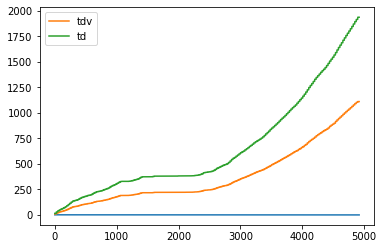

In [13]:
max_crown_temp = test_data['Maximum crown temperature(Tc max )']
min_crown_temp = test_data['Minimum crown temperature (Tcmin)']
min_temps = test_data['Minimum temperature)Tmin']
max_temps = test_data['Maximum temperature (Tmax)']
td_data = test_data['Td']

v_T_max = 30
v_T_min = 15
PIV= 1.5

t_leaf = (max_crown_temp+min_crown_temp)/2 # Crown temp

# TODO: Are these values coefficients?
a = 1.4-0.0778*t_leaf
b = 0.5+13.44*t_leaf/(max_temp-min_temp+3)**2.0
Vc = np.array([min(l1, l2) for l1, l2 in zip(a,b)])
V_pos = [v if min_temp < v_T_min and max_temp < v_T_max else 0 for v, min_temp, max_temp in zip(Vc, min_temps, max_temps )]
Vd = [min(0.5*(max_temp-v_T_max), 0) for max_temp in max_temps]
V_neg = [v if max_temp > v_T_max else 0 for v, max_temp in zip(Vd, max_temps)]

V = [a + b for a, b in zip(V_pos, V_neg)]
plt.plot(V)

Vf = [1- (0.0054545*PIV+0.0003)*(50-v)  for v in V]

TdV = [t * v for t, v in zip(td_data, Vf)]
plt.plot(TdV, label="tdv")
plt.plot(td_data, label='td')
plt.legend()



In [14]:
@interact_plus_reset(
    v_T_max = widgets.FloatSlider(min=0, max=40, step=0.1, value=30),
    v_T_min = widgets.FloatSlider(min=0, max=40, step=0.1, value=15),
    PIV= widgets.FloatSlider(min=0.1, max=3, step=0.1, value=1.5),
)
def run(
    v_T_max = 30,
    v_T_min = 15,
    PIV= 1.5,
):
    fig, axs = plt.subplots(nrows=3, figsize=(15, 2.1*4), dpi=120)
    max_crown_temp = test_data['Maximum crown temperature(Tc max )']
    min_crown_temp = test_data['Minimum crown temperature (Tcmin)']
    min_temps = test_data['Minimum temperature)Tmin']
    max_temps = test_data['Maximum temperature (Tmax)']
    td_data = test_data['Td']
    x = test_data['Day']

    axs[0].scatter(x, min_temps, label="min_temps")
    axs[0].scatter(x, max_temps, label="max_temps")
    axs[0].axhline(v_T_min, color="red")
    axs[0].axhline(v_T_max, color="red")

    t_leaf = (max_crown_temp+min_crown_temp)/2 # Crown temp

    # TODO: Are these values coefficients?
    a = 1.4-0.0778*t_leaf
    b = 0.5+13.44*t_leaf/(max_temp-min_temp+3)**2.0
    Vc = np.array([min(l1, l2) for l1, l2 in zip(a,b)])
    axs[1].plot(x, Vc, label="Vc")
    V_pos = [v if min_temp < v_T_min and max_temp < v_T_max else 0 for v, min_temp, max_temp in zip(Vc, min_temps, max_temps )]

    # TODO: Check what the min value should be here
    Vd = [min(0.5*(max_temp-v_T_max), 0) for max_temp in max_temps]
    # axs[1].plot(x, Vd, label="Vd")

    V_neg = [v if max_temp > v_T_max else 0 for v, max_temp in zip(Vd, max_temps)]
    axs[1].plot(x, V_pos, label="V_pos")
    axs[1].plot(x, V_neg, label="V_neg")
    V = [a + b for a, b in zip(V_pos, V_neg)]

    Vf = [1- (0.0054545*PIV+0.0003)*(50-v)  for v in V]

    TdV = [t * v for t, v in zip(td_data, Vf)]
    axs[2].plot(x, TdV, label="vernalised thermal time", linewidth=1, c="black")
    axs[2].plot(x, td_data, label="thermal time")
    axs[2].plot(x, test_data['Td (vernalised)'], label="test data thermal time", linestyle="--")


    for ax in axs:
        ax.legend()
        

Button(description='Reset', style=ButtonStyle())

Output()

In [15]:
@interact_plus_reset(
    v_T_max = widgets.FloatSlider(min=0, max=40, step=0.1, value=30),
    v_T_min = widgets.FloatSlider(min=0, max=40, step=0.1, value=15),
    PIV= widgets.FloatSlider(min=0.1, max=3, step=0.1, value=1.5),
)
def run(
    v_T_max = 30,
    v_T_min = 15,
    PIV= 1.5,
):
    fig, axs = plt.subplots(nrows=4, figsize=(20, 4*4))
    max_crown_temp = test_data['Maximum crown temperature(Tc max )']
    min_crown_temp = test_data['Minimum crown temperature (Tcmin)']
    min_temps = test_data['Minimum temperature)Tmin']
    max_temps = test_data['Maximum temperature (Tmax)']
    td_data = test_data['Td']

    axs[0].plot(min_temps, label="min_temps")
    axs[0].plot(max_temps, label="max_temps")
    axs[0].axhline(v_T_min)
    axs[0].axhline(v_T_max)

    t_leaf = (max_crown_temp+min_crown_temp)/2 # Crown temp

    # TODO: Are these values coefficients?
    a = 1.4-0.0778*t_leaf
    b = 0.5+13.44*t_leaf/(max_temp-min_temp+3)**2.0
    Vc = np.array([min(l1, l2) for l1, l2 in zip(a,b)])


    axs[1].set_title('Vc')
    axs[1].plot(Vc, label="python")
    axs[1].plot(test_data['V component'], label="test_data")



    V_pos = [v if min_temp < v_T_min and max_temp < v_T_max else 0 for v, min_temp, max_temp in zip(Vc, min_temps, max_temps )]

    # axs[1].set_title('V_pos')
    # axs[1].plot(V_pos, label="python")
    # axs[1].plot(test_data['V component'], label="test_data")

    # TODO: Check what the min value should be here
    Vd = [min(0.5*(max_temp-v_T_max), 0) for max_temp in max_temps]
    # axs[1].plot(Vd, label="Vd")

    V_neg = [vd if max_temp > v_T_max else 0 for vd, max_temp in zip(Vd, max_temps)]
    # axs[1].plot(V_pos, label="V_pos")
    # axs[1].plot(V_neg, label="V_neg")
    V = [a + b for a, b in zip(V_pos, V_neg)]

    
    Vf = [1- (0.0054545*PIV+0.0003)*(50-v)  for v in V]
    

    axs[2].set_title('Vf')
    axs[2].plot(Vf, label="python")
    axs[2].plot(test_data['Vernalisation factor (VF)'], label="test_data")
    TdV = [t * v for t, v in zip(td_data, Vf)]

    axs[3].set_title('Thermal Time (Vernalised)')
    axs[3].plot(TdV, label="python")
    axs[3].plot(test_data['Td (vernalised)'], label="test_data")


    for ax in axs:
        ax.legend()

Button(description='Reset', style=ButtonStyle())

Output()

Text(0.5, 1.0, 'Vacc')

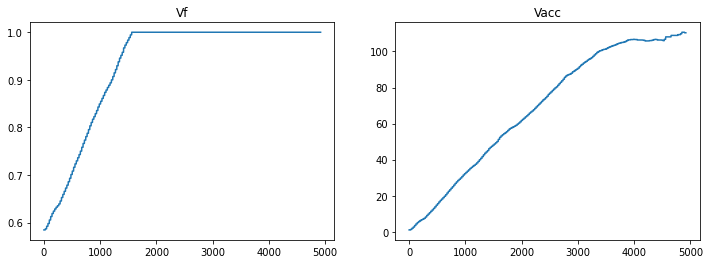

In [16]:
v_T_max=30
v_T_min=15
PIV=1.5

V_acc = 0
Vf = 0
Vf_values = []
V_acc_values = []
for i, row in test_data.iterrows():
    if row['Hour'] == 0:
        Vf, V_acc, v_pos, v_neg = calculate_vernalisation_factor(
            # max_crown_temp=row['Maximum crown temperature(Tc max )'],
            # min_crown_temp=row['Minimum crown temperature (Tcmin)'],
            max_ambient_temp=row['Maximum temperature (Tmax)'],
            min_ambient_temp=row['Minimum temperature)Tmin'],
            V_acc_prev=V_acc,
            phenology_stage=PhenologyStage.EMERGED,
            v_T_max=v_T_max,
            v_T_min=v_T_min,
            PIV=PIV,
        )
    Vf_values.append(Vf)
    V_acc_values.append(V_acc)

fig, axs = plt.subplots(ncols=2, figsize=(12,4))

axs[0].plot(Vf_values)
axs[0].set_title('Vf')
axs[1].plot(V_acc_values)
axs[1].set_title('Vacc')


4920
4920


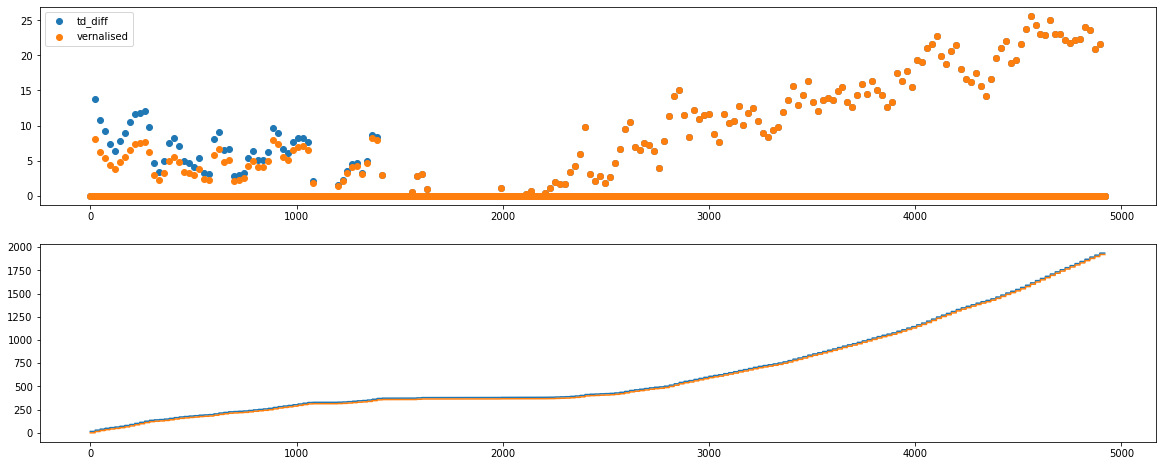

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
td_data = test_data['Td']
td_diff_data = [a - b for b, a in zip(td_data, td_data[1:])] + [0]
x = np.linspace(0, len(td_data), len(td_data))
print(len(td_data))
print(len(x))
axs[0].scatter(x, td_diff_data, label="td_diff")
t_emerg = 500
t_flower = 800

tdf_diff_data = [t * v for t, v in zip(td_diff_data, Vf_values)]
axs[0].scatter(x, tdf_diff_data, label="vernalised")
axs[0].legend()
from itertools import accumulate
tdf_data = [0]
for tdd, tddf in zip(td_diff_data, tdf_diff_data):
    t_acc = tdf_data[-1]
    t = t_acc + tddf if t_emerg < t_acc < t_flower else t_acc + tdd
    tdf_data.append(t)

plt.plot(td_data, label="td")
plt.plot(tdf_data, label="tdf")
# plt.legend()

# Full vernalisation model

The below interactive graph shows the effect of vernalisation on thermal time

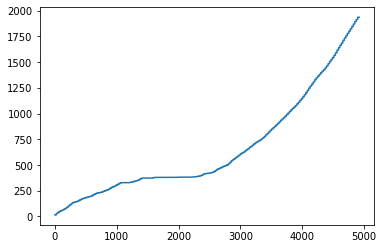

In [18]:
plt.plot(test_data['Td'])

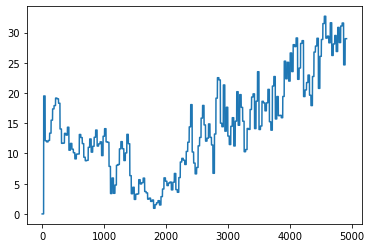

In [19]:
plt.plot(test_data['Maximum crown temperature(Tc max )'])

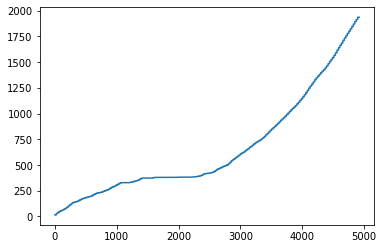

In [20]:
plt.plot(test_data['Td'])


# Full run

In [21]:
    # Altogether now!
@interact_plus_reset(
    v_T_max=widgets.FloatSlider(value=30, min=0, max=50, step=0.1),
    v_T_min=widgets.FloatSlider(value=15, min=0, max=50, step=0.1),
    PIV=widgets.FloatSlider(value=1.5, min=0, max=15, step=0.1),
    t_emerg=widgets.FloatSlider(value=385, min=0, max=2000, step=1),
    t_flower=widgets.FloatSlider(value=1000, min=0, max=2000, step=1),
)
def run(
        v_T_max=30,
        v_T_min=15,
        PIV=1.5,
        t_emerg = 385,
        t_flower = 1000,
    ):
        V_acc = 0
        Vf = 0
        Vf_values = []
        V_acc_values = []
        V_pos_values = []
        V_neg_values = []
        td_f_values = [0]
        prev_td = 0

        for i, row in test_data.iterrows():
            if row['Hour'] == 0:
                emerged = td_f_values[-1] > t_emerg
                phenology_stage = PhenologyStage.SOWN if not emerged else PhenologyStage.EMERGED
                Vf, V_acc, V_pos, V_neg = calculate_vernalisation_factor(
                    max_ambient_temp=row['Maximum temperature (Tmax)'],
                    min_ambient_temp=row['Minimum temperature)Tmin'],
                    V_acc_prev=V_acc,
                    phenology_stage=phenology_stage,
                    v_T_max=v_T_max,
                    v_T_min=v_T_min,
                    PIV=PIV,
                )
            Vf_values.append(Vf)
            V_acc_values.append(V_acc)
            V_pos_values.append(V_pos)
            V_neg_values.append(V_neg)
            td_diff = row['Td'] - prev_td
            td_f = td_f_values[-1] + td_diff * Vf
            td_f_values.append(td_f)
            prev_td = row['Td']
        
        x = test_data['Day'].values

        td_f_values = td_f_values[1:]
        fig, axs = plt.subplots(nrows=5, figsize=(15, 15), dpi=110)
        td_data = test_data['Td']
        td_diff_data = [a - b for b, a in zip(td_data, td_data[1:])] + [0]
        # x = np.linspace(0, len(td_data), len(td_data))
        axs[0].scatter(x, td_diff_data, label="td_diff", s=1)
        tdf_diff_data = [t * v for t, v in zip(td_diff_data, Vf_values)]
        axs[0].scatter(x, tdf_diff_data, label="vernalised", s=1)
        axs[0].legend()
        axs[0].set_title("Change in thermal time")

        tdf_data = [td_data[0]]
        for tdd, tddf in zip(td_diff_data, tdf_diff_data):
            t_acc = tdf_data[-1]
            t = t_acc + tddf if t_emerg < t_acc < t_flower else t_acc + tdd
            tdf_data.append(t)
        tdf_data = tdf_data[0:-1]
        axs[1].set_title("Thermal time")
        axs[1].scatter(x,td_data, label="td", s=1)
        axs[1].scatter(x,tdf_data, label="tdf", s=1)
        axs[1].axhline(t_emerg, c="red")
        axs[1].axhline(t_flower, c="red")
        axs[1].legend()

        # axs[2].plot(x, V_acc_values)
        axs[2].set_title("vernalisation")
        axs[2].scatter(x, V_pos_values, label="pos", s=1)
        axs[2].scatter(x, V_neg_values, label="neg", s=1)
        axs[2].legend()

        axs[3].axhline(1, c="red")
        axs[3].set_title("vernalisation factor")
        axs[3].scatter(x, Vf_values, label="Vf", s=1)
        axs[3].legend()
        
        axs[4].set_title("vernalisation Accumulation")
        axs[4].scatter(x, V_acc_values, label="V_acc", s=1)
        axs[4].legend()
        # plt.plot(x, td_f_values)
        # plt.plot(x, test_data['Td'])
plt.show()

Button(description='Reset', style=ButtonStyle())

Output()

In [35]:
# Using V_tot instead of V_acc
@interact_plus_reset(
    v_T_max=widgets.FloatSlider(value=30, min=0, max=50, step=0.1),
    v_T_min=widgets.FloatSlider(value=15, min=0, max=50, step=0.1),
    PIV=widgets.FloatSlider(value=1.5, min=0, max=15, step=0.1),
    t_emerg=widgets.FloatSlider(value=385, min=0, max=2000, step=1),
    t_flower=widgets.FloatSlider(value=1000, min=0, max=2000, step=1),
)
def run(
        v_T_max=30,
        v_T_min=15,
        PIV=1.5,
        t_emerg = 385,
        t_flower = 1000,
    ):
        V_acc = 0
        Vf = 0
        Vf_values = []
        V_acc_values = []
        V_pos_values = []
        V_neg_values = []
        td_f_values = [0]
        prev_td = 0
        emerg_dd = None
        flowering_dd = None

        for i, row in test_data.iterrows():
            if row['Hour'] == 0:
                emerged = td_f_values[-1] > t_emerg
                flowering = td_f_values[-1] > t_flower
                
                emerg_dd = row['Day'] if emerged and emerg_dd is None else emerg_dd
                flowering_dd = row['Day']  if flowering and flowering_dd is None else flowering_dd

                phenology_stage = PhenologyStage.SOWN if not emerged else PhenologyStage.EMERGED if not flowering else PhenologyStage.ASTART
                Vf, V_acc, V_pos, V_neg = calculate_vernalisation_factor(
                    max_ambient_temp=row['Maximum temperature (Tmax)'],
                    min_ambient_temp=row['Minimum temperature)Tmin'],
                    V_acc_prev=0,
                    phenology_stage=phenology_stage,
                    v_T_max=v_T_max,
                    v_T_min=v_T_min,
                    PIV=PIV,
                )
            Vf_values.append(Vf)
            V_acc_values.append(V_acc)
            V_pos_values.append(V_pos)
            V_neg_values.append(V_neg)
            td_diff = row['Td'] - prev_td
            td_f = td_f_values[-1] + td_diff * Vf
            td_f_values.append(td_f)
            prev_td = row['Td']
        
        x = test_data['Day'].values

        fig, axs = plt.subplots(nrows=5, figsize=(15, 15), dpi=110)
        td_data = test_data['Td'].values
        td_diff_data = [a - b for b, a in zip(td_data, td_data[1:])] + [0]
        tdf_diff_data = [t * v for t, v in zip(td_diff_data, Vf_values)]

        axs[0].scatter(x, td_diff_data, label="td_diff", s=1)
        axs[0].scatter(x, tdf_diff_data, label="vernalised", s=1)
        axs[0].legend()
        axs[0].set_title("Change in thermal time")

        axs[1].set_title("Thermal time")
        axs[1].scatter(x,td_data, label="td", s=1)
        axs[1].scatter(x,td_f_values[1:], label="tdf", s=1)
        axs[1].axhline(t_emerg, c="green")
        axs[1].axhline(t_flower, c="red")
        print(emerg_dd)
        axs[1].axvline(emerg_dd, c="green")
        axs[1].axvline(flowering_dd, c="red")
        axs[1].legend()

        # axs[2].plot(x, V_acc_values)
        axs[2].set_title("vernalisation")
        axs[2].scatter(x, V_pos_values, label="pos", s=1)
        axs[2].scatter(x, V_neg_values, label="neg", s=1)
        axs[2].legend()

        axs[3].axhline(1, c="red")
        axs[3].set_title("vernalisation factor")
        axs[3].scatter(x, Vf_values, label="Vf", s=1)
        axs[3].legend()
        
        axs[4].set_title("vernalisation Accumulation")
        axs[4].scatter(x, V_acc_values, label="V_acc", s=1)
        axs[4].legend()
        # plt.plot(x, td_f_values)
        # plt.plot(x, test_data['Td'])
plt.show()

Button(description='Reset', style=ButtonStyle())

Output()


# Show with phenology

In [23]:
# from do3se_phenology.config import PhenologyMethods, SpeciesPresets, SpeciesConfig, ModelConfig
# from dataclasses import replace
# from copy import deepcopy

# phenology_config = SpeciesConfig(
#     PRESET=SpeciesPresets.WHEAT_SPRING,
# )

# model_config = ModelConfig(
#     phenology_method=PhenologyMethods.SEASON_FRACTION,
# )

# species_config = replace(
#     deepcopy(phenology_config)
# )

# species_config.key_dates.sowing = 20
# species_config.key_dates_td.sowing = 0
# species_config.key_lengths_td.sowing_to_end = 2000
# species_config.f_phen_min = 0.1

# nP = 3
# processed_model_config, processed_species_config =  process_phenology_config(
#     model_config=model_config ,
#     species_config=species_config ,
#     external_data=None ,
#     td_base_temperature=0,
#     nP=nP,
# )

# plot_phenology_from_config(species_config, model_config, nP = 3)

In [24]:

# from do3se_phenology.config import PhenologyMethods, SpeciesPresets, SpeciesConfig, ModelConfig
# from dataclasses import replace
# from copy import deepcopy
# nrows = 2


# phenology_config = SpeciesConfig(
#     PRESET=SpeciesPresets.WHEAT_SPRING,
# )

# model_config = ModelConfig(
#     phenology_method=PhenologyMethods.SEASON_FRACTION,
# )

# species_config = replace(
#     deepcopy(phenology_config)
# )

# species_config.key_dates.sowing = 20
# species_config.key_dates_td.sowing = 0
# species_config.key_lengths_td.sowing_to_end = 300
# species_config.f_phen_min = 0.1
# processed_model_config, processed_species_config = process_phenology_config(
#     model_config,
#     species_config,
#     external_data=None,
#     td_base_temperature=0,
#     nP=nP,
# )
# # ===== PLOTS ===== #
# fig, axs = plt.subplots(ncols=1, nrows=nrows, figsize=(10, nrows*5), dpi=120)
# axs = axs if nrows  >1 else [axs]

# plot_leaf_f_phen_data_from_config(processed_species_config, test_data['Td'], ax=axs[0])
# plot_ewert_phenology_data_from_config(processed_species_config, test_data['Td'], ax=axs[0])
# for ax in axs:
#     ax.legend()
